In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import random
import missingno as msno
import tensorflow as tf
import os
import tensorflow_hub as hub
%matplotlib inline
import tokenization
from wildnlp.aspects import SentimentMasking, RemoveChar, QWERTY, Digits2Words #Misspellings
from wildnlp.aspects.utils import compose

In [2]:
composed = compose(SentimentMasking(), RemoveChar(), QWERTY())

In [4]:
train = pd.read_csv('../dataset/train_processed.csv')

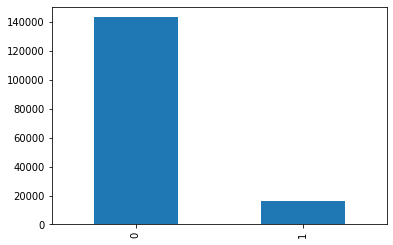

In [5]:
pd.value_counts(train['class']).plot.bar()

In [6]:
train_0_class = train[train['class'] == 0]

In [7]:
train_1_class = train[train['class'] == 1]

In [8]:
difference = len(train_0_class) - len(train_1_class)
print(difference)
train_1_class_augmented = train_1_class.sample(n=difference, replace=True)

127121


In [9]:
train_1_class_augmented

,idx,comment_text,class
114199,62fcd99ef23e6a62,101 caps? \n\nhe hasn't actually achieved 101 ...,1
83826,e059323f5004591a,Shut the fuck up faggot.. I've had fucking 100...,1
126925,a6dbef4eddf9000b,5>STOP EDITING MY POSTS DIPSHIT \nI HAVE A RIG...,1
20134,352e48dbc439501a,waste of oxygen \n\nEven amongst jerkoff wikil...,1
106683,3a9ae6d7c46eebe6,WHAT A DISGRACE !!!! \n\nAren't you ashamed of...,1
...,...,...,...
136253,d8dcc3b93c281e2c,"With is pointless talking,in my books just an...",1
63786,aaac9ffc6d386655,RYULONG ADMIN NOMINATION \n\nPlease see my not...,1
64054,ab6c1a6716fdfbe1,"Harassment \n\nSeriously, stop pulling that ri...",1
102616,252b47fe435c0607,"Oh, give me a break. If you'd been watching m...",1


In [10]:
train_1_class_augmented['comment_text'] = train_1_class_augmented['comment_text'].apply(composed)

In [11]:
train_df = pd.concat([train_0_class, train_1_class, train_1_class_augmented])

In [12]:
train_df['class'].value_counts()

1    143346
0    143346
Name: class, dtype: int64

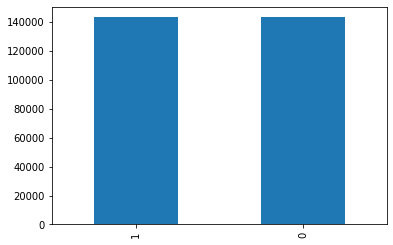

In [13]:
pd.value_counts(train_df['class']).plot.bar()

In [22]:
train_df.set_index('idx').to_csv('../dataset/train_augmented.csv')

In [3]:
train_df = pd.read_csv('../dataset/train_augmented.csv', index_col='idx')

In [4]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1", trainable = True)

In [5]:
MAX_LEN = 128

def make_tokenizer(bert_layer):
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    cased = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = tokenization.FullTokenizer(vocab_file, cased)
  
    return tokenizer

tokenizer = make_tokenizer(bert_layer)

In [10]:
from tqdm import tqdm

In [11]:
def preprocess(data, max_seq_length = MAX_LEN, tokenizer = tokenizer):
    ids = []
    masks = []
    segment = []
    for sentence in tqdm(data):
        
        tokens = tokenizer.tokenize(sentence)
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[ : max_seq_length - 2]

        # Converting tokens to ids
        input_ids = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens + ["[SEP]"])

        # Input mask
        input_masks = [1] * len(input_ids)

        # padding upto max length
        padding = max_seq_length - len(input_ids)
        input_ids.extend([0] * padding)
        input_masks.extend([0] * padding)
        segment_ids =[0]* max_seq_length
        
        
        ids.append(input_ids)
        masks.append(input_masks)
        segment.append(segment_ids)
    
    return (np.array(ids), np.array(masks), np.array(segment))

In [13]:
train_ids, train_masks, train_segment = preprocess(train_df["comment_text"].values)

np.save('../dataset/train_ids.npy', train_ids)
np.save('../dataset/train_masks.npy', train_masks)
np.save('../dataset/train_segment.npy', train_segment)

train_ids = np.load('../dataset/train_ids.npy')
train_masks = np.load('../dataset/train_masks.npy')
train_segment = np.load('../dataset/train_segment.npy')

y_train = train_df["class"].values

In [14]:
test = pd.read_csv('../dataset/test_processed.csv')
test_df = test[test['class'] != -1]
pd.value_counts(test_df['class']).plot.bar()

In [33]:
test_ids, test_masks, test_segment =  preprocess(test_df["comment_text"].values)

np.save('../dataset/test_ids.npy', test_ids)
np.save('../dataset/test_masks.npy', test_masks)
np.save('../dataset/test_segment.npy', test_segment)

test_ids = np.load('../dataset/test_ids.npy')
test_masks = np.load('../dataset/test_masks.npy')
test_segment = np.load('../dataset/test_segment.npy')

y_test = test_df['class'].values

100%|██████████| 63978/63978 [00:47<00:00, 1360.22it/s]


In [34]:
len(test_ids)

63978

In [35]:
len(y_test)

63978

In [36]:
def model(bert_layer, max_len = MAX_LEN):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    # There are two outputs: a pooled_output of shape [batch_size, 768] with representations for 
    # the entire input sequences and a sequence_output of shape [batch_size, max_seq_length, 768] 
    # with representations for each input token (in context)
    x = pooled_output
    x = tf.keras.layers.Dense(256, activation = "relu")(x)
    x = tf.keras.layers.Dense(1, activation = "sigmoid")(x)
    
    model = tf.keras.Model(inputs = [input_word_ids, input_mask, segment_ids], outputs = x)
    model.compile(tf.keras.optimizers.Adam(lr=2e-6), loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

In [37]:
model = model(bert_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [38]:
model.load_weights('model.h5')

In [ ]:
history = model.fit(
    (train_ids, train_masks, train_segment), y_train,
    epochs=1,
    batch_size=16
)

model.save('model_longer.h5')

Epoch 1/3
16051/17919 [=========================>....] - ETA: 3:43 - loss: 0.2898 - accuracy: 0.9074

In [43]:
model.evaluate((train_ids, train_masks, train_segment), y_train)

  30/8960 [..............................] - ETA: 5:12:40 - loss: 1.5113 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [39]:
model.evaluate((test_ids, test_masks, test_segment), y_test)

 187/2000 [=>............................] - ETA: 1:04:46 - loss: 0.4202 - accuracy: 0.8239

KeyboardInterrupt: 

In [119]:
text = test_df[test_df['class'] == 1]['comment_text'].iloc[:10].values

In [120]:
from pprint import pprint

In [121]:
pprint(list(zip(text, model.predict(preprocess(text))[:, 0])))

[('== Arabs are committing genocide in Iraq, but no protests in Europe. == \n'
  '\n'
  ' May Europe also burn in hell.',
  0.1264993),
 ('DJ Robinson is gay as hell! he sucks his dick so much!!!!!', 0.75454813),
 (':Fuck off, you anti-semitic cunt.  |', 0.8810549),
 ("How dare you vandalize that page about the HMS Beagle! Don't vandalize "
  'again, demon!',
  0.7442208),
 ('::No, he is an arrogant, self serving, immature idiot. Get it right.',
  0.34355053),
 (':Eek, but shes cute in an earthy kind of way. Cant sing for shit though. '
  'Thanks for giving me an unhappy memory.',
  0.46735078),
 ("::::Well, it sucks to have a university to be nicknameless. And it's the "
  'first time in NCAA history that it has happened. /',
  0.24752381),
 ('== Argh == \n\n Some random idiot deleted the whole Japan article <.',
  0.11568985),
 ('(we hate america and we are going to bomb the shit out of there cities, '
  'Queza;s will rain)',
  0.5047228),
 ('== Bold textYOU SUCK!!! == \n\n  \n\n U S

In [51]:
test_df['comment_text'].iloc[0]

'Thank you for understanding. I think very highly of you and would not revert without discussion.'

In [59]:
test_df[test_df['class'] == 1]['comment_text'].iloc[:10].values

array(['== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.',
       'DJ Robinson is gay as hell! he sucks his dick so much!!!!!',
       ':Fuck off, you anti-semitic cunt.  |',
       "How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",
       '::No, he is an arrogant, self serving, immature idiot. Get it right.',
       ':Eek, but shes cute in an earthy kind of way. Cant sing for shit though. Thanks for giving me an unhappy memory.',
       "::::Well, it sucks to have a university to be nicknameless. And it's the first time in NCAA history that it has happened. /",
       '== Argh == \n\n Some random idiot deleted the whole Japan article <.',
       '(we hate america and we are going to bomb the shit out of there cities, Queza;s will rain)',
       '== Bold textYOU SUCK!!! == \n\n  \n\n U SUCK HANNAH MONTANA'],
      dtype=object)